<a href="https://colab.research.google.com/github/cindyhfls/NMA_DL_2021_project/blob/main/Copy_of_neuro_seq_to_seq_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focus on what matters: inferring low-dimensional dynamics from neural recordings

**By Neuromatch Academy**

__Content creators:__ Marius Pachitariu, Pedram Mouseli, Lucas Tavares, Jonny Coutinho, 
Blessing Itoro, Gaurang Mahajan, Rishika Mohanta

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective: 
It is very difficult to interpret the activity of single neurons in the brain, because their firing patterns are noisy, and it is not clear how a single neuron can contribute to cognition and behavior. However, neurons in the brain participate in local, regional and brainwide dynamics. No neuron is isolated from these dynamics, and much of a single neuron's activity can be predicted from the dynamics. Furthermore, only populations of neurons as a whole can control cognition and behavior. Hence it is crucial to identify these dynamical patterns and relate them to stimuli or behaviors. 

In this notebook, we generate simulated data from a low-dimensional dynamical system and then use seq-to-seq methods to predict one subset of neurons from another. This allows us to identify the low-dimensional dynamics that are sufficient to explain the activity of neurons in the simulation. The methods described in this notebook can be applied to large-scale neural recordings of hundreds to tens of thousans of neurons, such as the ones from the NMA-CN course.

---
# Setup

In [1]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [151]:
def pearson_corr_tensor(input, output):
  rpred = output.detach().cpu().numpy()
  rreal = input.detach().cpu().numpy()
  rpred_flat = np.ndarray.flatten(rpred)
  rreal_flat = np.ndarray.flatten(rreal)
  corrcoeff = np.corrcoef(rpred_flat, rreal_flat)
  return corrcoeff[0,1]

**Note:** If `cuda` is not enabled, go to `Runtime`--> `Change runtime type` and in `Hardware acceleration` choose `GPU`. 

---
# Simulate some data from a linear dynamical system

In [187]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

# we simulate 200 neurons
NN = 300
NN1 = 200
NN2 = NN-NN1

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0_NN1 =  np.diag(.8 + .2 * np.random.rand(ncomp,))
A0_NN2 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0_NN1 = .025 * np.random.randn(ncomp, NN1)
C0_NN2 = .025 * np.random.randn(ncomp, NN2)

# We generate the dynamics of the low-d system. We initialize the latent state.

# start by initializing the latents
y       = 2 * np.random.randn(ncomp)
y2       = 2 * np.random.randn(ncomp) # add the inputs here

latents = np.zeros((NT, ntrials, ncomp))
latents2 = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep

w = 2*np.random.randn(ncomp) # for input, w = randn
# w = np.zeros(ncomp)# for autonomous, w = 0
b = 0

for t in range(NT):
  y2 = y2 @ A0_NN2 +  np.random.randn(ntrials, ncomp) 
  # y = y @ A0_NN1 +  np.random.randn(ntrials, ncomp) 
  y = (y+w*y2+b) @ A0_NN1 +  np.random.randn(ntrials, ncomp) 
  latents[t]  = y+w*y2+b
  latents2[t] = y2

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0_NN1)
rates2 = np.maximum(0, latents2 @ C0_NN2)

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
x1 = np.random.poisson(rates)
x0 = np.random.poisson(rates2)

#Our RNN model

In [188]:
class Net(nn.Module): # our model
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn1 = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0, # MO
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.rnn2 = nn.RNN(NN2,ncomp,num_layers = 1, dropout = 0, bidirectional = bidi, nonlinearity = 'tanh') #TH

    if bidi == True:
      self.fclatent = nn.Linear(ncomp*2,ncomp*2)
    else: 
      self.fclatent = nn.Linear(ncomp,ncomp)

    self.fc = nn.Linear(ncomp,NN1)

  def forward(self, x0,x1):
    y2 = self.rnn2(x0)[0] # ncomp TH
    y =  self.rnn1(x1)[0] # ncomp MOs
    yout = y+self.fclatent(y2) # ncomp MOs with projection of latent TH components

    if self.rnn1.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (yout[:, :, :ncomp] + yout[:, :, ncomp:])/2
    else:
      q = yout

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q, y, y2

In [189]:
# we separate the neuron data into two populations: MOs and TH
# x0 = torch.from_numpy(x[:, :, :200]).to(device).float() # dims: ntimebins * ntrials * nneurons
# x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()

x0 = torch.from_numpy(x0).to(device).float()
x1 = torch.from_numpy(x1).to(device).float()

trial_divide = [math.floor(ntrials*0.6),math.floor(ntrials*0.9)]

x0_train = x0[:,:trial_divide[0],:]
x0_val = x0[:,trial_divide[0]:trial_divide[1],:]
x0_test = x0[:,trial_divide[1]:,:]

x1_train = x1[:,:trial_divide[0],:]
x1_val = x1[:,trial_divide[0]:trial_divide[1],:]
x1_test = x1[:,trial_divide[1]:,:]

NN1 = x1.shape[-1]
NN2 = x0.shape[-1]


# Comparing two models trained side-by-side (not freezing weight)

In [190]:
# load saved model
net_baseline = Net(ncomp, NN1, NN2, bidi = False).to(device)
net_baseline.fclatent.weight.data[:] = 0
net_baseline.fclatent.bias.data[:] = 0
net_baseline.fclatent.weight.requires_grad = False
net_baseline.fclatent.bias.requires_grad = False
net_baseline.fc.bias.data[:] = x1.mean((0,1))

net_withinput  = Net(ncomp, NN1, NN2, bidi = False).to(device)
net_withinput.fc.bias.data[:] = x1.mean((0,1))


In [191]:
# @title train loop
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

def train(net,niter = 1000):
  optimizer = torch.optim.Adam(net.parameters(), lr=.005)
  training_cost = []
  val_cost = []
  for k in range(niter):
    ### training
    optimizer.zero_grad()
    # the network outputs the single-neuron prediction and the latents
    z,_,_,_ = net(x0_train,x1_train)
    # our log-likelihood cost
    cost = Poisson_loss(z, x1_train).mean()
    # train the network as usual
    cost.backward()
    optimizer.step()
    training_cost.append(cost.item())

    ### test on validation data
    z_val,_,_,_ = net(x0_val,x1_val)
    cost = Poisson_loss(z_val, x1_val).mean()
    val_cost.append(cost.item())

    if k % 100 == 0:
      print(f'iteration {k}, cost {cost.item():.4f}')
    
  return training_cost,val_cost

In [192]:
# train baseline
training_cost_baseline,val_cost_baseline = train(net_baseline,niter = 1000)
# train withinput
training_cost_withinput,val_cost_withinput = train(net_withinput,niter = 1000)

iteration 0, cost 0.8431
iteration 100, cost -0.3144
iteration 200, cost -0.5254
iteration 300, cost -0.6570
iteration 400, cost -0.7463
iteration 500, cost -0.7988
iteration 600, cost nan
iteration 700, cost nan
iteration 800, cost nan
iteration 900, cost nan
iteration 0, cost 0.8331
iteration 100, cost -0.4287


KeyboardInterrupt: ignored

(0.2, 0.4)

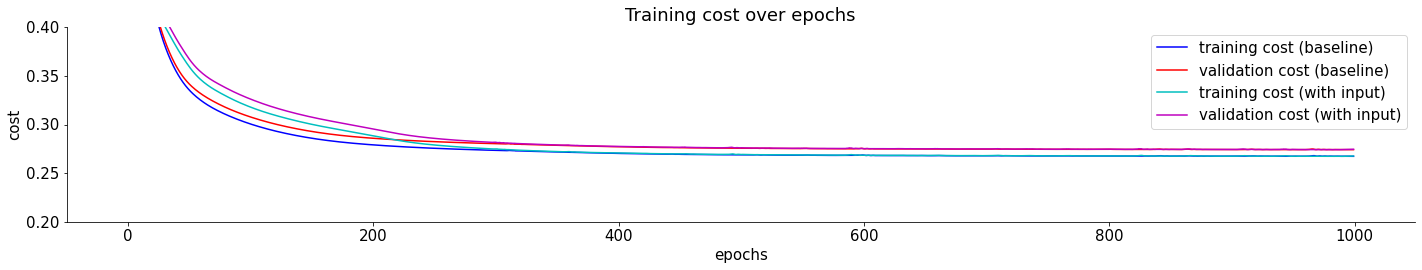

In [130]:
#@title plot the training side-by-side
plt.plot(training_cost_baseline,'b')
plt.plot(val_cost_baseline,'r')
plt.plot(training_cost_withinput,'c')
plt.plot(val_cost_withinput,'m')
# plt.hlines(np.min(training_cost_baseline),0,niter,'b',linestyles = '--')
# plt.hlines(np.min(val_cost_baseline),0,niter,'r',linestyles = '--')

plt.legend(['training cost (baseline)','validation cost (baseline)','training cost (with input)','validation cost (with input)'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')


plt.ylim(0.2,0.4)

Text(0.5, 1.0, 'fclatent weight')

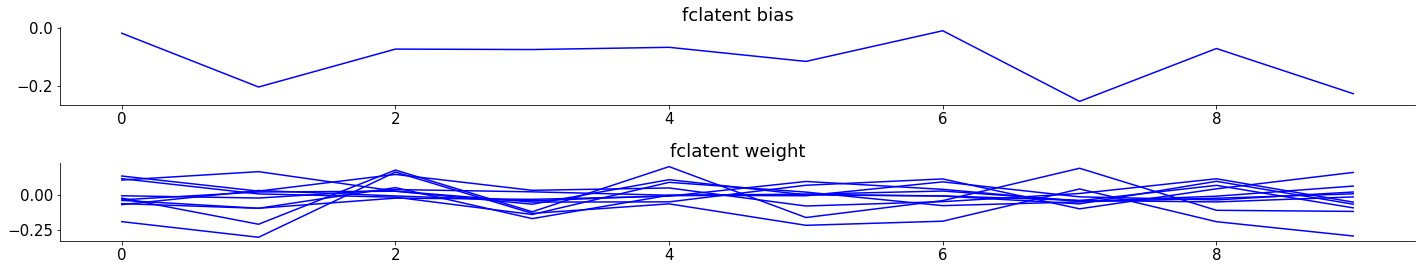

In [150]:
plt.subplot(2,1,1)
plt.plot(net_withinput.fclatent.bias.detach().cpu(),'b')
plt.title('fclatent bias')
plt.subplot(2,1,2)
plt.plot(net_withinput.fclatent.weight.detach().cpu(),'b')
plt.title('fclatent weight')

In [165]:
print(pearson_corr_tensor(net_baseline.fc.weight, net_withinput.fc.weight))
print(pearson_corr_tensor(net_baseline.fc.bias, net_withinput.fc.bias))

0.04477273518872251
0.25185712270114563


# Can we predict latent components in rnn1 with latent components in rnn2?

In [166]:
_,_,yy,yy2 = net_withinput(x0_train,x1_train)
yy = yy.detach().cpu().flatten(start_dim=0, end_dim=2).reshape(-1, 1)
yy2 = yy2.detach().cpu().flatten(start_dim=0, end_dim=2).reshape(-1, 1)

In [167]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(yy, yy2)
r_sq = model.score(yy, yy2)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.0011593050521490067


---
# Compare true firing rates with the predicted.

Note that for real data we only get the spikes, not the true firing rates! 

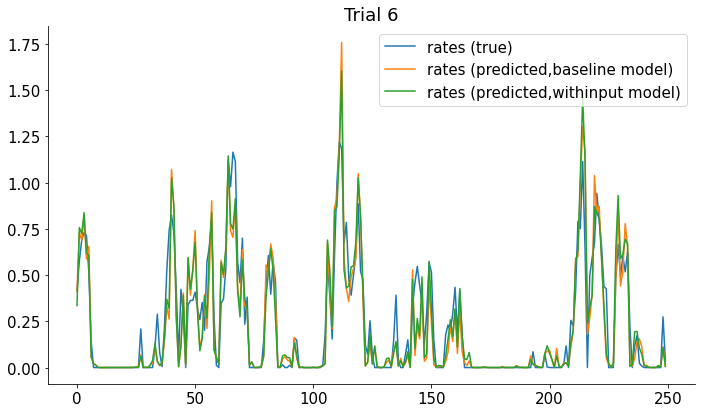

In [184]:
# training data
z_baseline,_,_,_ = net_baseline(x0_train,x1_train)
z_withinput,_,_,_ = net_withinput(x0_train,x1_train)
rpred_baseline = z_baseline.detach().cpu().numpy()
rpred_withinput = z_withinput.detach().cpu().numpy()
nTr = 6
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nTr, 0])
plt.plot(rpred_baseline[:,nTr, 0])
plt.plot(rpred_withinput[:,nTr, 0])

plt.legend(['rates (true)', 'rates (predicted,baseline model)','rates (predicted,withinput model)'])
plt.title(f'Trial {nTr}')
plt.show()

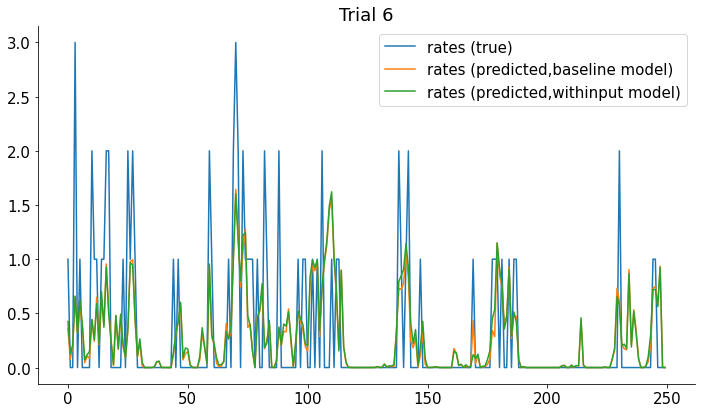

In [186]:
# test data
z_baseline,_,_,_ = net_baseline(x0_test,x1_test)
z_withinput,_,_,_ = net_withinput(x0_test,x1_test)
rpred_baseline = z_baseline.detach().cpu().numpy()
rpred_withinput = z_withinput.detach().cpu().numpy()
nTr = 6
plt.figure(figsize=(10, 6))
plt.plot(x1_test[:,nTr, 0])
plt.plot(rpred_baseline[:,nTr, 0])
plt.plot(rpred_withinput[:,nTr, 0])

plt.legend(['rates (true)', 'rates (predicted,baseline model)','rates (predicted,withinput model)'])
plt.title(f'Trial {nTr}')
plt.show()

## View firing rates for all neurons in one trial

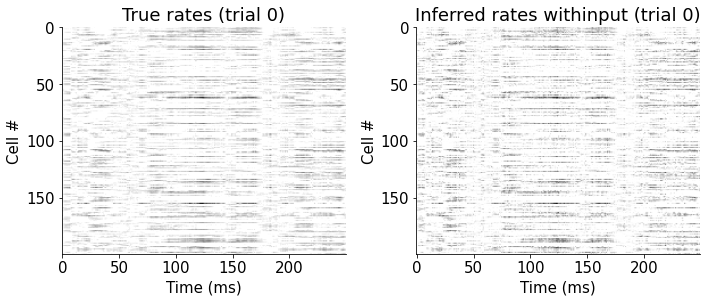

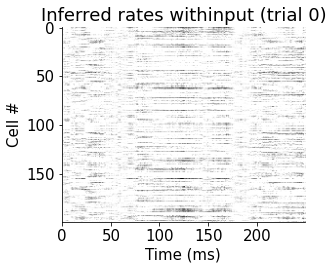

In [177]:
nTr = 0
plt.figure(figsize = (15, 8))
plt.subplot(1,3,1)
plt.imshow(rates[:, nTr, :200].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'True rates (trial {nTr})')

plt.subplot(1,3,2)
plt.imshow(rpred_baseline [:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates withinput (trial {nTr})')
plt.show()


plt.subplot(1,3,3)
plt.imshow(rpred_withinput [:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates withinput (trial {nTr})')
plt.show()

In [181]:
#@title: predict on test set
print('For net_baseline:')
z, y,_,_ = net_baseline(x0_test,x1_test)
cost = Poisson_loss(z, x1_test).mean()
print(f'Test cost is %1.3f'%cost.tolist())
corr = pearson_corr_tensor(x1_test, z)
print(f'Correlation is %1.3f'%corr)

print('For net_withinput:')
z, y,_,_ = net_withinput(x0_test,x1_test)
cost = Poisson_loss(z, x1_test).mean()
print(f'Test cost is %1.3f'%cost.tolist())
corr = pearson_corr_tensor(x1_test, z)
print(f'Correlation is %1.3f'%corr)

For net_baseline:
Test cost is 0.279
Correlation is 0.593
For net_withinput:
Test cost is 0.280
Correlation is 0.593


---
# Visualize the latent dynamics

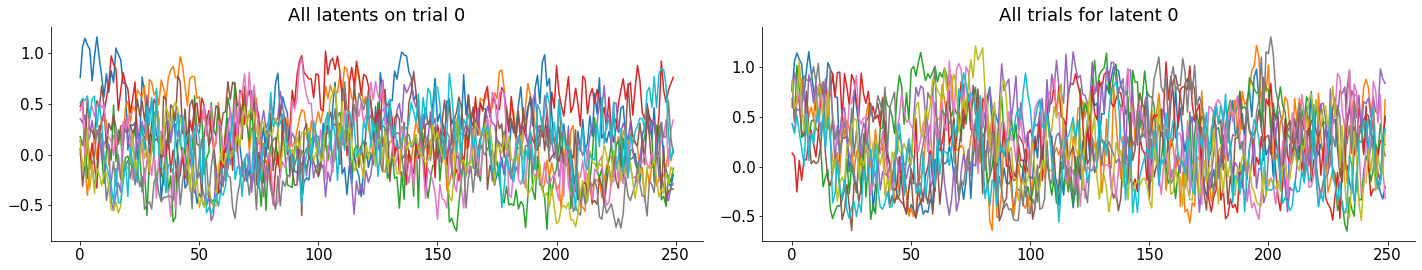

In [182]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0]);
plt.title('All trials for latent 0')
plt.show()

In [183]:
# check that the latent-latent has zero weight
net_baseline.fclatent.weight

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
# save model (first on colab environment but you can download it https://neptune.ai/blog/google-colab-dealing-with-files)
PATH = "simulated_model.pt"
torch.save(net_baseline.state_dict(), PATH) 

In [16]:
 # load saved model
net_baseline = Net(ncomp, NN1, NN2, bidi = True).to(device)
net_baseline.load_state_dict(torch.load('simulated_model.pt'))

<All keys matched successfully>

---
# Model with input

In [28]:
# after training the baseline network, get the weights of rnn1 and freeze it
import copy
net_withinput  = copy.deepcopy(net_baseline)
net_withinput.fclatent.weight.requires_grad = True
net_withinput.fclatent.bias.requires_grad = True

net_withinput.rnn1.weight_ih_l0.requires_grad = False
net_withinput.rnn1.weight_hh_l0.requires_grad = False
net_withinput.rnn1.bias_ih_l0.requires_grad = False
net_withinput.rnn1.bias_hh_l0.requires_grad = False
net_withinput.rnn1.weight_ih_l0_reverse.requires_grad = False
net_withinput.rnn1.weight_hh_l0_reverse.requires_grad = False
net_withinput.rnn1.bias_ih_l0_reverse.requires_grad = False
net_withinput.rnn1.bias_hh_l0_reverse.requires_grad = False

In [18]:
net_withinput.rnn1.bias_hh_l0.requires_grad

False

In [19]:
# check that the latent-latent has learned weight
net_baseline.fclatent.weight.requires_grad

True

In [29]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

optimizer = torch.optim.Adam(net_withinput.parameters(), lr=.005)

niter = 200
training_cost = []
val_cost = []
for k in range(niter):
  ### training
  optimizer.zero_grad()
  # the network outputs the single-neuron prediction and the latents
  z, y = net_withinput(x0_train,x1_train)
  # our log-likelihood cost
  cost = Poisson_loss(z, x1_train).mean()
  # train the network as usual
  cost.backward()
  optimizer.step()
  training_cost.append(cost.item())

  ### test on validation data
  z_val,_ = net_withinput(x0_val,x1_val)
  cost = Poisson_loss(z_val, x1_val).mean()
  val_cost.append(cost.item())

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


iteration 0, cost 0.3060
iteration 100, cost 0.3049


Text(0.5, 0, 'epochs')

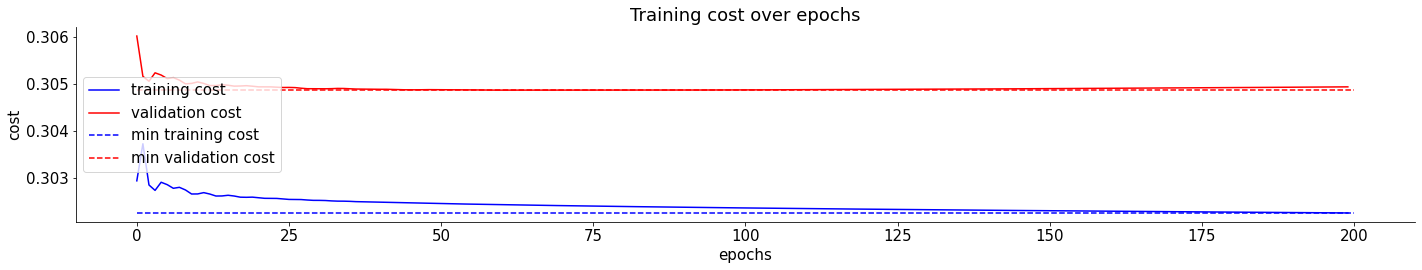

In [30]:
plt.plot(training_cost,'b')
plt.plot(val_cost,'r')
plt.hlines(np.min(training_cost),0,niter,'b',linestyles = '--')
plt.hlines(np.min(val_cost),0,niter,'r',linestyles = '--')

plt.legend(['training cost','validation cost','min training cost','min validation cost'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')

---
# Compare true firing rates with the predicted.

Note that for real data we only get the spikes, not the true firing rates! 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


(250, 60, 200)


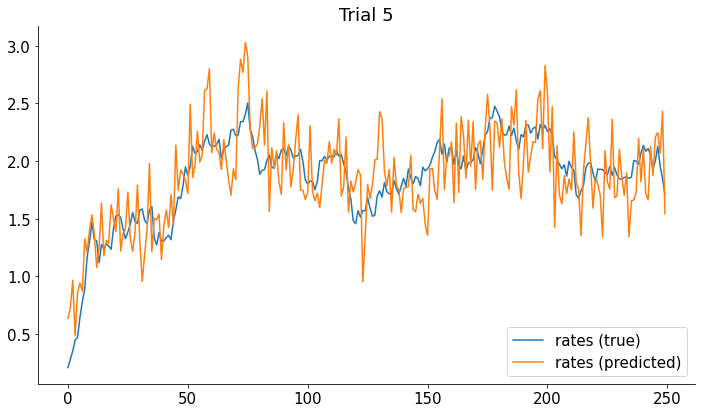

In [31]:
z, y = net_withinput(x0_train,x1_train)
rpred = z.detach().cpu().numpy()
print(rpred.shape)
nTr = 5
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nTr, 0])
plt.plot(rpred[:,nTr, 0])

plt.legend(['rates (true)', 'rates (predicted)'])
plt.title(f'Trial {nTr}')
plt.show()

## View firing rates for all neurons in one trial

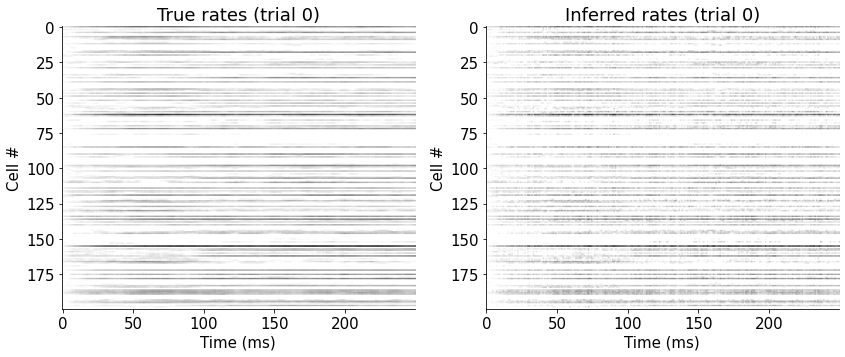

In [32]:
nTr = 0
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, nTr, :200].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'True rates (trial {nTr})')

plt.subplot(122)
plt.imshow(rpred[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (trial {nTr})')
plt.show()

In [33]:
#@title: predict on test set
z, y = net_withinput(x0_test,x1_test)
cost = Poisson_loss(z, x1_test).mean()

print(f'Test cost is %1.3f'%cost.tolist())
def pearson_corr_tensor(input, output):
  rpred = output.detach().cpu().numpy()
  rreal = input.detach().cpu().numpy()
  rpred_flat = np.ndarray.flatten(rpred)
  rreal_flat = np.ndarray.flatten(rreal)
  corrcoeff = np.corrcoef(rpred_flat, rreal_flat)
  return corrcoeff[0,1]

corr = pearson_corr_tensor(x1_test, z)
print(f'Correlation is %1.3f'%corr)

Test cost is 0.307
Correlation is 0.727


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [ ]:
z1, y = net_baseline(x0_train,x1_train)
z2, y = net_withinput(x0_train,x1_train)
corr = pearson_corr_tensor(z1,z2)
print(f'Correlation is %1.3f'%corr)